In [1]:
import jax.numpy as np
from jax import grad, jit, vmap
from jax import random

In [2]:
N = 2
rcpt_types = 3
t = np.arange(0,5000.1, 0.1)
fs = np.arange(0, 101, 1)
fs = fs/1000 #convert from Hz to kHz
c = np.array([0, 25, 50, 100])
cons = len(c)

#[1.7 -1.525; 1.7 -0.5]
Jee = 1.7
Jei = 1.525
Jie = 1.7
Jii = 0.5 
i2e = 0.6

J0 = np.array([[Jee, -Jei], [Jie, -Jii]])
J0

/Users/cholt/Google Drive/Python/torch_SSN/jax/jax/lib/xla_bridge.py:109: UserWarning: No GPU/TPU found, falling back to CPU.
  warnings.warn('No GPU/TPU found, falling back to CPU.')


DeviceArray([[ 1.70000005, -1.52499998],
             [ 1.70000005, -0.5  ]], dtype=float32)

In [3]:
W = J0
print('Det(W) =', '%.3f' % np.linalg.det(W))

#define nonlinearity parameters
kk = 0.04
nn = 2

if rcpt_types > 1:
    g = np.array([1, i2e, 0, 0, 0, 0])
else:
    g = np.array([1, i2e])

tauE = 15
tau_ratio = 1
tauI = tauE/tau_ratio

# tau = np.ones(N)
# tau[:2:] = tauE
# tau[1:2:] = tauI

t_scale = 1
tauNMDA = 100 * t_scale
tauAMPA = 3 * t_scale
tauGABA = 5 * t_scale
nmdaRatio = 0.1 # sets the ratio of NMDA cells to AMPA cell 

NoiseNMDAratio = 0
NoiseTau = 1 * t_scale


totalT = t[-1]
dt = np.mean(np.diff(t))
dt2 = np.sqrt(dt)

Det(W) = 1.742


In [4]:
if rcpt_types > 1:
    tauS = np.array([tauAMPA, tauNMDA, tauGABA])
    tauSvec = np.kron(tauS, np.ones(N))
    
    Wtot = np.array([[(1-nmdaRatio)*Jee, 0, 0, 0, 0, 0], [(1-nmdaRatio)* Jie, 0, 0, 0, 0, 0], [0, 0, nmdaRatio * Jee, 0, 0, 0], [0, 0, nmdaRatio * Jie, 0, 0, 0], [0, 0, 0, 0, 0, -Jei], [0, 0, 0, 0, 0, -Jii]])
    
else:
    tauSvec = tau
    Wrcpt = W
    Wtot = W
    

In [46]:
v1 = np.zeros([N*rcpt_types, cons])
r_starcons = np.zeros([N, cons])

vv_t = np.zeros([len(t), N*rcpt_types, cons])
# v1 = np.zeros(N*rcpt_types)
# r_t = np.zeros([len(t), N, cons])
# tt_c = np.zeros([len(t), cons])

In [16]:
def rect_powerLaw(vv, kk, nn):
    fv = kk*np.maximum(np.array([np.sum(vv[::2,:], axis=0), np.sum(vv[1::2,:],axis=0)]), np.zeros([N, cons]))**nn
    return fv

def dvdt(vv):
    delta_v = np.reshape(dt/tauSvec, [6,1]) * (-vv + Wtot @ np.kron(np.ones([rcpt_types,1]), rect_powerLaw(vv, kk ,nn)) + I_total)
    return delta_v


In [17]:
I_total = np.kron( g.reshape(N*rcpt_types,1),  c.reshape(1,cons))
# I_total = np.kron(c, g)
# I_total = np.transpose(np.reshape(I_total, [4, 6]))
I_total

DeviceArray([[  0.      ,  25.      ,  50.      , 100.      ],
             [  0.      ,  15.00000095,  30.00000191,  60.00000381],
             [  0.      ,   0.      ,   0.      ,   0.      ],
             [  0.      ,   0.      ,   0.      ,   0.      ],
             [  0.      ,   0.      ,   0.      ,   0.      ],
             [  0.      ,   0.      ,   0.      ,   0.      ]],
            dtype=float32)

In [47]:
Conv = True
indt = 0
xtol = 1e-3
xmin = 1
vv_t =[]

for tt in t:

    dv = dvdt(v1)
    v1 = dv + v1
    vv_t.append(v1)
    indt += 1
    
    if np.abs( dv /np.maximum(xmin, np.abs(v1)) ).max() < xtol:
            # print('\n converged to fixed point at t=%g,      as max(abs(dx./max(xvec,%g))) < %g \n' % (n*dt,xmin,xtol))
            # CONVG = 1
            print(tt)
            break
    
    if tt >= totalT - 1000*dt:
        itr = np.max(np.abs(dv))
        
        if itr > 0.01:
            Conv = False

60.1


602
(601,)
60.1


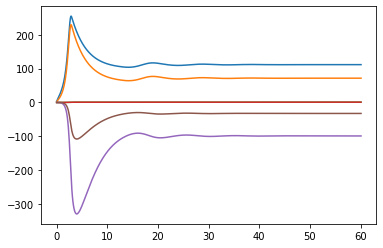

In [48]:
print(len(vv_t))
print(np.arange(0,tt, dt).shape)
print(tt)

# import matplotlib.pyplot as plt

plt.plot(np.arange(0,tt+dt, dt), np.array(vv_t)[:,:,4])

In [14]:
r_starcons = rect_powerLaw(v1, kk, nn)
rs = nn*kk**(1/nn)*r_starcons**(1-1/nn)
v1

DeviceArray([[  0.       ,  36.47018433,  63.64902878, 111.50494385],
             [  0.       ,  26.4701767,  43.64903259,  71.50494385],
             [  0.       ,   1.27440214,   1.51650786,   1.27829814],
             [  0.       ,   1.27440214,   1.51650786,   1.27829814],
             [  0.       , -24.05441475, -50.23153305, -99.07230377],
             [  0.       ,  -7.88669729, -16.46936035, -32.48272324]],
            dtype=float32)

In [30]:
Gf = -1j * 2 * np.pi * ff * np.diag(np.kron(tauS, np.ones(N))) - J
Gf.shape

(6, 6)

In [12]:
Phi = lambda rr: np.diag(rr)
eE = np.array([[1], [0]])
eE = np.kron(np.ones([rcpt_types,1]), eE)
J = np.array([[Wtot @ np.kron(np.ones([rcpt_types, rcpt_types]), Phi(rs[:,cc])) -np.eye(N*rcpt_types)] for cc in range(cons)])
Gf = np.array([-1j * 2 * np.pi * ff * np.diag(np.kron(tauS, np.ones(N))) - J[cc,1] for cc in range(cons) for ff in fs])

cuE = np.array([eE for cc in range(cons) for ff in fs])
fscons = np.kron(np.ones([1, cons]), fs)

In [13]:
# iGf = np.linalg.inv(Gf)

# x = np.einsum("ijk, ikm-> ijm", iGf, cuE)
# x = np.matmul(iGf, cuE)
x = np.linalg.solve(Gf, cuE)

y = (1-NoiseNMDAratio) * x[:, :N] + NoiseNMDAratio * x[:, N:(N+N)]
y_conj = np.transpose(np.conj(y), [0, 2, 1])

# spect = np.einsum('ijk, imk -> ijm', y_conj, y)
tapercons = 2 * NoiseTau/np.abs(-1j * 2 * np.pi * fscons * NoiseTau + 1)**2

spect = np.squeeze(np.matmul(y_conj, y)) * np.squeeze(tapercons)

spect = np.reshape(spect*2/1000, [len(fs), cons], order='F')
spect = spect/np.mean(spect)


In [283]:
x[:, N:2*N].shape

(404, 2, 1)

In [14]:
import matplotlib.pyplot as plt

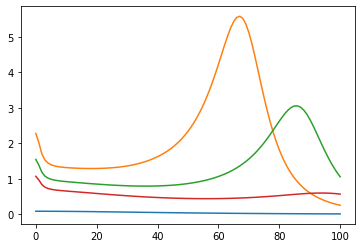

In [15]:
plt.plot(fs*1000, np.real(spect))

In [257]:
tapercons.shape

(1, 404)

In [206]:
A = np.array([[1, 2, 3], [4, 5, 6], [7, 8, 9]])
B = np.ones_like(A)
C = np.einsum("ij, jl -> il", A, B)
C

DeviceArray([[ 6,  6,  6],
             [15, 15, 15],
             [24, 24, 24]], dtype=int32)

In [237]:
a = np.array([[[1., 2.], [3., 4.]], [[1, 3], [3, 5]]])
inv_a = np.linalg.inv(a)
inv_a

DeviceArray([[[-2.00000024,  1.00000012],
              [ 1.50000012, -0.50000006]],

             [[-1.25000012,  0.75000006],
              [ 0.75000006, -0.25000003]]], dtype=float32)

In [297]:
def sum_logistic(x):
    return np.sum(1.0 / (1.0 + np.exp(-x)))


In [302]:
x_small = np.arange(3.)
derivative_fn = grad(sum_logistic)
print(derivative_fn(x_small))

sum_logistic(x_small)

[0.25       0.19661197 0.10499357]


DeviceArray(2.1118555, dtype=float32)

In [303]:
def first_finite_differences(f, x):
  eps = 1e-3
  return np.array([(f(x + eps * v) - f(x - eps * v)) / (2 * eps)
                   for v in np.eye(len(x))])


print(first_finite_differences(sum_logistic, x_small))

[0.24998187 0.1964569  0.10502338]


In [271]:
np.linalg.inv(Gf[102])

DeviceArray([[ 2.02596545+0.00523263j, -1.38562214-0.00588392j,
               0.75048965+0.43859053j, -1.00262594-0.60973394j,
               1.02608693-0.00072046j, -1.38500178-0.02327667j],
             [ 1.02632082-0.01361023j, -0.38597748+0.01295893j,
               0.75048971+0.43859062j, -1.00262606-0.609734j  ,
               1.02608693-0.00072046j, -1.3850019 -0.02327668j],
             [ 0.08338774+0.04873229j, -0.11140289-0.06774823j,
               0.75615603+0.52226734j, -0.05121355-0.09782675j,
               0.08274308+0.04975992j, -0.11050843-0.06912006j],
             [ 0.08338774+0.04873229j, -0.11140289-0.06774823j,
               0.03919928+0.0717901j ,  0.66574323+0.35265046j,
               0.08274307+0.04975992j, -0.11050843-0.06912005j],
             [-1.49702525-0.07363215j,  0.67005605+0.08570754j,
              -1.05383956-0.70756078j,  0.4486399 +0.35496598j,
              -0.49649641-0.06101178j,  0.66871572+0.0940856j ],
             [-0.49082792-0.0241416

In [270]:
Gf[102]

DeviceArray([[-0.67567706-0.01884956j,  0.        +0.j        ,
              -1.67567706+0.j        ,  0.        +0.j        ,
              -1.67567706+0.j        ,  0.        +0.j        ],
             [-1.67567706+0.j        ,  1.        -0.01884956j,
              -1.67567706+0.j        ,  0.        +0.j        ,
              -1.67567706+0.j        ,  0.        +0.j        ],
             [-0.18618634+0.j        ,  0.        +0.j        ,
               0.81381369-0.62831855j,  0.        +0.j        ,
              -0.18618634+0.j        ,  0.        +0.j        ],
             [-0.18618634+0.j        ,  0.        +0.j        ,
              -0.18618634+0.j        ,  1.        -0.62831855j,
              -0.18618634+0.j        ,  0.        +0.j        ],
             [ 0.        +0.j        ,  2.42266154+0.j        ,
               0.        +0.j        ,  2.42266154+0.j        ,
               1.        -0.03141593j,  2.42266154+0.j        ],
             [ 0.        +0.j      

In [1]:
import jax.numpy as np
from jax import grad, jit, vmap
from jax import random

from rates_2D import loss 

In [2]:
Jee = 1.8
Jei = 1.525
Jie = 1.7
Jii = 0.5 
i2e = 0.6

derivative_loss = grad(loss, argnums=(0,1,2,3,4))

dJee, dJei, dJie, dJii, di2e = derivative_loss(Jee, Jei, Jie, Jii, i2e)
print([dJee, dJei, dJie, dJii, di2e])

/Users/cholt/Google Drive/Python/torch_SSN/jax/jax/lib/xla_bridge.py:109: UserWarning: No GPU/TPU found, falling back to CPU.
  warnings.warn('No GPU/TPU found, falling back to CPU.')


91.5


/Users/cholt/Google Drive/Python/torch_SSN/jax/jax/lax/lax.py:328: ComplexWarning: Casting complex values to real discards the imaginary part
  warnings.warn(msg, onp.ComplexWarning)


[DeviceArray(0., dtype=float32), DeviceArray(-0., dtype=float32), DeviceArray(0., dtype=float32), DeviceArray(-0., dtype=float32), DeviceArray(0., dtype=float32)]


IndexError: Too many indices for array: 1 non-None/Ellipsis indices for dim 0.

In [32]:
Phi = lambda rr: np.diag(rr)
eE = np.array([[1], [0]])
eE = np.kron(np.ones([rcpt_types,1]), eE)

spect = np.zeros([cons, len(fs)])

for cc in np.arange(cons):
    indf = 0
    J = Wtot @ np.kron(np.ones([rcpt_types, rcpt_types]), Phi(rs[:,cc])) -np.eye(N*rcpt_types)
    
    for ff in fs:
        Gf = -1j * 2 * np.pi * ff * np.diag(np.kron(tauS, np.ones(N))) - J
        x = np.linalg.solve(Gf, eE)
        
        y = (1-NoiseNMDAratio) * x[:, :N] + NoiseNMDAratio * x[:, N:(N+N)]
        y_conj = np.transpose(np.conj(y))
        
        spect[cc, indf] = (y_conj @ y) * 2 * NoiseTau/np.abs(-1j * 2 * np.pi * ff * NoiseTau + 1)**2
        
        indf += 1


TypeError: '<class 'jax.lax.lax._FilledConstant'>' object does not support item assignment. JAX arrays are immutable; perhaps you want jax.ops.index_update or jax.ops.index_add instead?